## MNIST 이미지로 CNN 구현
###### 코드 설명이 되어있는 링크 https://medium.com/@inmoonlight/pytorch%EB%A1%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%95%98%EA%B8%B0-cnn-62a9326111ae
###### cnn 설명이 잘 되어있는 링크 https://medium.com/@hobinjeong/cnn-convolutional-neural-network-9f600dd3b395
###### cnn 설명이 잘 되어있는 링크 https://mc.ai/cnn%EC%97%90%EC%84%9C-pooling%EC%9D%B4%EB%9E%80/

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.1307,), (0.3081,)) # image, label
                             ]))

# trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4,
#                                           shuffle=True, num_workers=2,
#                                          )

mnist_testset = datasets.MNIST(root='./data', train=False, download=True,  transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.1307,), (0.3081,)) # image, label
                             ]))



batch_size = 64
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                         )


testloader = torch.utils.data.DataLoader(mnist_testset,batch_size=batch_size,
                                         shuffle=False, num_workers=2)



## 전처리 과정에 대해



##### *num_worders 는 thread 수

### 정리하자면 원래 이미지는 [0,255] torchvision은  [0,1]의 범위로 만들고 이를 [-1,1]로 한번더 바꿔 주었다.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


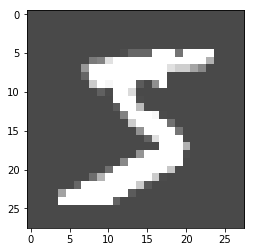

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize([0,1]로 범위를 바꿔줌)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(mnist_trainset)
images, labels = next(dataiter);

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))


## 용어 설명
#### convolution : 3*3 같은 크기로 (도장처럼) 처리하기 - > 3*3의 가중치가 있고 (activtion(가중치*각 픽셀))의 과정
#### padding : 크기가 작아진 이미지에 padding을 더하기
#### pooling : 특징 뽑아내기(크기가 작아진다)(max pooling, avg pooling 등이 있고 과적합을 막는다)
#### 다시 원래의 이미지 크기로 확대

#### output 채널의 계산

    Total size ; N (i.e. N x N)

    Filter size ; F (i.e. F x F)

    Output size ; k:=(N-F)/stride + 1 where k is an integer.
    예를들어 N =7*7 F = 3*3 stride= 1 이면 outputsize는(7-3)/1 +1 =5
    
#### reshape 함수 https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch
        array의 행과 열을 변형해준다.



### Conv2d

#### class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

Conv2d의 parameters는 차례대로 in_channels, out_channels, kernel_size, stride, padding, diction , groups, bias 가 있다.


필수 요소로는 in_channels, out_channels,kernel_size 가있다. 


in_channels(int) : input image의 channel수 이다. rgb이미지라면 3이 되겠다.


out_channels(int) : convolution에 의해서 생성된 channel의 수 이다. -> output의 픽셀 가로 세로가 아님.


kernel_size(int or tuple) : convoling_kenel 의 크기이다. 보통은 filter라고 부르는 것과 동일하다.


stride(int or tuple) : convolution의 stride를 얼만큼 줄 것이가 이다. Default는 1이다.


padding(int or tuple) : zero padding을 input의 양쪽에 인자 만큼 해준다. Default는 0이라서 기본적으로 설정해주지 않으면 zero padding은 하지 않는다.

In [50]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5) # input channels, output channels, kernel size
#         self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride, padding = 0 (default)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120) # input features, output features
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

      # 항상 torch.nn.Module을 상속받고 시작
        self.conv1 = nn.Conv2d(1, 6, 5, 1) # 6@24*24 24가 어디서 나왔을까? mnist data의 한 이미지 크기는 28. 위의 공식 대입하여(28-5)/1+!=24, #채널을 6개로 만듬
        # activation ReLU
        self.pool1 = nn.MaxPool2d(2) # 6@12*12 2*2로 pooling 하면 이미지의 크기가 절반이 된다.
        self.conv2 = nn.Conv2d(6, 16, 5, 1) # 16@8*8 #아까 채널이 6개니까 지금의 Input이 6
        # activation ReLU
        self.pool2 = nn.MaxPool2d(2) # 16@4*4 #pooling 2로 하면 이미지 크기가 절반이 된다.
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # input features, output features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 2
num_batches = len(trainloader)


trn_loss_list = []
val_loss_list = []


In [62]:
for epoch in range(num_epochs):  # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,   100] loss: 0.009
[1,   200] loss: 0.007
[1,   300] loss: 0.007
[1,   400] loss: 0.007
[1,   500] loss: 0.006
[1,   600] loss: 0.006
[1,   700] loss: 0.005
[1,   800] loss: 0.006
[1,   900] loss: 0.006
[2,   100] loss: 0.005
[2,   200] loss: 0.005
[2,   300] loss: 0.006
[2,   400] loss: 0.005
[2,   500] loss: 0.005
[2,   600] loss: 0.005
[2,   700] loss: 0.005
[2,   800] loss: 0.005
[2,   900] loss: 0.005
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


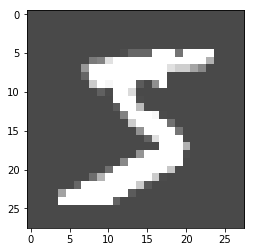